Run the following command to set up the environment

In [ ]:
! pip install --quiet "ipython[notebook]==7.34.0, <8.17.0" "setuptools>=68.0.0, <68.3.0" "tensorboard" "lightning>=2.0.0" "urllib3" "torch==2.3.0" "matplotlib" "pytorch-lightning>=1.4, <2.1.0" "seaborn" "torchvision" "torchmetrics>=0.7, <1.3" "matplotlib>=3.0.0, <3.9.0"
! pip install --quiet "pandas" "timm" "Pillow"

Import the necessary libraries to build the model and enable the GPU runtime to be used for training and testing

In [ ]:
import os
import sys
import time
from PIL import Image
from glob import glob
from zipfile import ZipFile

import torch
from torch import nn, optim, autograd
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from dataclasses import dataclass
import torchmetrics
from torchmetrics.regression import R2Score
import timm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Allows Matplotlib plots to be directly in Jupyter notebook
%matplotlib inline
torch.set_num_threads(1)
torch.manual_seed(1)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

if device == torch.device("cuda:0"):
  print('GPU is being uitlized')
else:
  print('CPU is beign utilized')

GPU is being uitlized


In [ ]:
@dataclass
class HyperParameter:
    num_epochs              = 7
    batch_size              = 32
    image_size              = 128
    num_classes             = 6
    target_columns          = ["X4_mean", "X11_mean", "X18_mean", "X26_mean", "X50_mean", "X3112_mean"]
    num_targets             = len(target_columns)
    tabular_columns         = []
    num_tabular             = 0
    imagenet_mean           = [0.485, 0.456, 0.406]
    imagenet_std            = [0.229, 0.224, 0.225]

hp = HyperParameter()

Extract and load in the training and testing data from the local file ./cs-480-2024-spring.zip. Preprocess data according to the article by Schiller et al. (https://www.nature.com/articles/s41598-021-95616-0#Sec8):
- log 10 transformation of target data due to skewed distribution
- removing outliers exceeding three sd above or below the mean
- normalize tabular and target data in training and testing datasets


In [ ]:
if not os.path.exists("./data"):
  file_name = "./cs-480-2024-spring.zip"

  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Data extracted from cs-480-2024-spring.zip')

train_df = pd.read_csv("./data/train.csv")
train_df['image_path'] = train_df['id'].map(lambda x: os.path.join("./data/train_images", str(x) + ".jpeg"))

test_df = pd.read_csv("./data/test.csv")
test_df['image_path'] = test_df['id'].map(lambda x: os.path.join("./data/test_images", str(x) + ".jpeg"))

# Get all of the tabular data columnn headers
tabular_df = train_df.drop(columns=hp.target_columns + ["id", "image_path"])
hp.tabular_columns = tabular_df.columns.tolist()
hp.num_tabular = len(hp.tabular_columns)

# Log10 transformation of target data
for target in hp.target_columns:
  train_df[target] = np.log10(train_df[target])

# Remove outliers by excluding data points that are more than 3 sd above/below the mean
for target in hp.target_columns:
  mean = train_df[target].mean()
  std = train_df[target].std()
  train_df = train_df[(train_df[target] >= mean - 3 * std) & (train_df[target] <= mean + 3 * std)]

train_df = train_df.reset_index(drop=True)

# Normalize all target data by the min and max values of the training dataset
min_train = train_df[hp.target_columns].min()
max_train = train_df[hp.target_columns].max()

train_df[hp.target_columns] = (train_df[hp.target_columns] - min_train) / (max_train - min_train)

# Normalize all tabular data by the min and max values of the training dataset
min_tabular_train = train_df[hp.tabular_columns].min()
max_tabular_train = train_df[hp.tabular_columns].max()

train_df[hp.tabular_columns] = (train_df[hp.tabular_columns] - min_tabular_train) / (max_tabular_train - min_tabular_train)

# Normalize all tabular data by the min and max values of the testing dataset
min_tabular_test = test_df[hp.tabular_columns].min()
max_tabular_test = test_df[hp.tabular_columns].max()

test_df[hp.tabular_columns] = (test_df[hp.tabular_columns] - min_tabular_test) / (max_tabular_test - min_tabular_test)

# Split the training dataset into a smaller training dataset and a validation dataset
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(train_df[hp.target_columns])

        X4_mean  X11_mean  X18_mean  X26_mean  X50_mean  X3112_mean
0      0.413353  0.783107  0.007990  0.001006  0.622491    0.006343
1      0.570230  0.494840  0.045815  0.011340  0.562159    0.165977
2      0.606471  0.391805  0.165167  0.179637  0.412035    0.104762
3      0.471746  0.806133  0.031036  0.003680  0.420758    0.279641
4      0.500050  0.337867  0.024380  0.003104  0.631353    0.055317
...         ...       ...       ...       ...       ...         ...
31276  0.517644  0.309422  0.034051  0.005548  0.384507    0.021233
31277  0.422703  0.220551  0.052294  0.164234  0.986910    0.077676
31278  0.545151  0.582676  0.015435  0.006344  0.413219    0.096768
31279  0.700399  0.526743  0.015018  0.000578  0.386385    0.011297
31280  0.573589  0.149256  0.011264  0.006287  0.981963    0.007188

[31281 rows x 6 columns]


Define transforms that will convert each image into a tensor and add augmentations to ensure that the data does not overfit.

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=hp.imagenet_mean, std=hp.imagenet_std),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=hp.imagenet_mean, std=hp.imagenet_std),
    ]
)

class TrainingDataset(Dataset):
  def __init__(self, dataframe, image_column, tabular_columns, target_columns, transform):
    self.dataframe = dataframe
    self.image_column = image_column
    self.tabular_columns = tabular_columns
    self.target_columns = target_columns
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.loc[index, self.image_column]
    image = Image.open(image_path)
    image = self.transform(image)

    tabulars = self.dataframe.loc[index, self.tabular_columns].values
    if tabulars.dtype == 'object':
      tabulars = np.array(tabulars, dtype=np.float32)

    targets = self.dataframe.loc[index, self.target_columns].values
    if targets.dtype == 'object':
      targets = np.array(targets, dtype=np.float32)

    return image, tabulars, targets


train_dataset = TrainingDataset(train_df, image_column="image_path", tabular_columns=hp.tabular_columns, target_columns=hp.target_columns, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=hp.batch_size, shuffle=True)

val_dataset = TrainingDataset(val_df, image_column="image_path", tabular_columns=hp.tabular_columns, target_columns=hp.target_columns, transform=test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=hp.batch_size, shuffle=False)

class TestingDataset(Dataset):
  def __init__(self, dataframe, image_column, tabular_columns, transforms):
    self.dataframe = dataframe
    self.image_column = image_column
    self.tabular_columns = tabular_columns
    self.transforms = transforms

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    id = self.dataframe.loc[index, "id"]

    image_path = self.dataframe.loc[index, self.image_column]
    image = Image.open(image_path)
    image = self.transforms(image)

    tabulars = self.dataframe.loc[index, self.tabular_columns].values
    if tabulars.dtype == 'object':
      tabulars = np.array(tabulars, dtype=np.float32)

    return id, image, tabulars

test_dataset = TestingDataset(test_df, image_column="image_path", tabular_columns=hp.tabular_columns, transforms=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

We will be implementing the mixed data model featured in the article written by Schiller et al. (https://www.nature.com/articles/s41598-021-95616-0#Sec8). Using EfficientNetB0 as the baseline CNN model, the image branch consists of two dense layers of 512 and 256 output units while the tabular data branch consists of three dense layers of 512, 256, and 128 output units. Finally, the two branches are concatenated and passed through the final four linear layers to output the six predicted traits.

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.pretrain_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        num_features = self.pretrain_model.num_features

        # Fully connected layers for the image branch
        self.image_fc = nn.Linear(num_features, 512)
        self.image_bn = nn.BatchNorm1d(512)
        self.image_fc_out = nn.Linear(512, 256)

        # Fully connected layers for the tabular data branch
        self.tabular_fc1 = nn.Linear(hp.num_tabular, 512)
        self.tabular_bn1 = nn.BatchNorm1d(512)
        self.tabular_fc2 = nn.Linear(512, 256)
        self.tabular_bn2 = nn.BatchNorm1d(256)
        self.tabular_fc_out = nn.Linear(256, 128)

        # Fully connected layers for combining branches
        self.combine_fc1 = nn.Linear(384, 512)
        self.combine_bn1 = nn.BatchNorm1d(512)
        self.combine_fc2 = nn.Linear(512, 512)
        self.combine_bn2 = nn.BatchNorm1d(512)
        self.combine_fc3 = nn.Linear(512, 256)
        self.combine_bn3 = nn.BatchNorm1d(256)
        self.combine_fc_out = nn.Linear(256, 6)

        # Activation function
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()

        # Dropout Layer
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, image, tabular_data):
        # Forward pass of image branch
        x = self.pretrain_model(image)
        x = x.view(x.size(0), -1)
        x = self.silu(self.image_bn(self.image_fc(x)))
        image_features = self.image_fc_out(x)

        # Forward pass of tabular data branch
        t = self.relu(self.tabular_bn1(self.tabular_fc1(tabular_data)))
        t = self.dropout(t)
        t = self.relu(self.tabular_bn2(self.tabular_fc2(t)))
        tabular_features = self.tabular_fc_out(t)

        # Forward pass of combinining the image and tabular data branches
        combined_features = torch.cat((image_features, tabular_features), dim=1)
        combined_features = self.relu(self.combine_bn1(self.combine_fc1(combined_features)))
        combined_features = self.dropout(combined_features)
        combined_features = self.relu(self.combine_bn2(self.combine_fc2(combined_features)))
        combined_features = self.dropout(combined_features)
        combined_features = self.relu(self.combine_bn3(self.combine_fc3(combined_features)))
        output = self.combine_fc_out(combined_features)

        return output

model = Model()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Model(
  (pretrain_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

Define the optimizer and loss function to be used for the training process. Note that the decision to use an OneCycleLr scheduler to dynamically adjust learning rates during training and the choice of SmoothL1Loss as the loss function was inspired from the following article (https://www.kaggle.com/code/hdjojo/modified-planttraits2024-eda-training)

In [ ]:
R2 = R2Score(num_outputs=hp.num_classes, multioutput='uniform_average').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=3e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=hp.num_epochs,
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=10,
)

loss_function = nn.SmoothL1Loss()

Now train the model with the training dataset and test the model with the validation dataset after each epoch to ensure that the model is not overfitting

In [ ]:
training_r2 = [0] * hp.num_epochs
validation_r2 = [0] * hp.num_epochs

for epoch in range(hp.num_epochs):
  R2.reset()
  model.train()

  for i, (images, tabulars, targets) in enumerate(train_dataloader):
    if i % 300 == 0:
      print(f"Batch [{i+1}/{len(train_dataloader)}]")

    images = images.to(device)
    targets = targets.to(device)
    tabulars = tabulars.to(device)

    optimizer.zero_grad()
    outputs = model(images, tabulars)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step()

    R2.update(outputs, targets)

  r2_score = R2.compute()
  training_r2[epoch] = r2_score
  print(f"Epoch [{epoch+1}/{hp.num_epochs}], Training R2 Score: {r2_score:.4f}")

  R2.reset()
  model.eval()
  with torch.no_grad():
    for i, (images, tabulars, targets) in enumerate(val_dataloader):
      images = images.to(device)
      tabulars = tabulars.to(device)
      targets = targets.to(device)

      outputs = model(images, tabulars)

      R2.update(outputs, targets)

  r2_score = R2.compute()
  validation_r2[epoch] = r2_score
  print(f"Epoch [{epoch+1}/{hp.num_epochs}], Validation R2 Score: {r2_score:.4f}")

Batch [1/978]
Batch [301/978]
Batch [601/978]
Batch [901/978]
Epoch [1/7], Training R2 Score: -1.5927
Epoch [1/7], Validation R2 Score: 0.1360
Batch [1/978]
Batch [301/978]
Batch [601/978]
Batch [901/978]
Epoch [2/7], Training R2 Score: 0.1021
Epoch [2/7], Validation R2 Score: 0.1902
Batch [1/978]
Batch [301/978]
Batch [601/978]
Batch [901/978]
Epoch [3/7], Training R2 Score: 0.1647
Epoch [3/7], Validation R2 Score: 0.2021
Batch [1/978]
Batch [301/978]
Batch [601/978]
Batch [901/978]
Epoch [4/7], Training R2 Score: 0.2030
Epoch [4/7], Validation R2 Score: 0.2252
Batch [1/978]
Batch [301/978]
Batch [601/978]
Batch [901/978]
Epoch [5/7], Training R2 Score: 0.2357
Epoch [5/7], Validation R2 Score: 0.2354
Batch [1/978]
Batch [301/978]
Batch [601/978]
Batch [901/978]
Epoch [6/7], Training R2 Score: 0.2700
Epoch [6/7], Validation R2 Score: 0.2412
Batch [1/978]
Batch [301/978]
Batch [601/978]
Batch [901/978]
Epoch [7/7], Training R2 Score: 0.2960
Epoch [7/7], Validation R2 Score: 0.2325


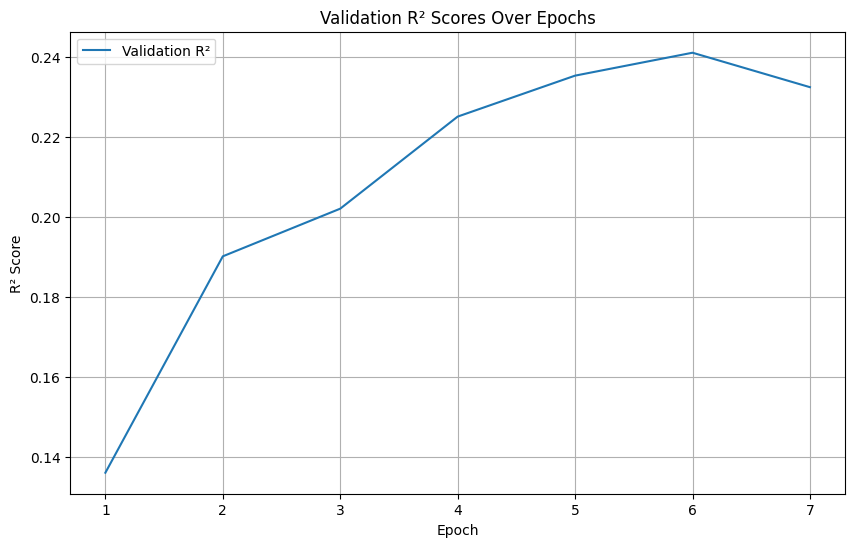

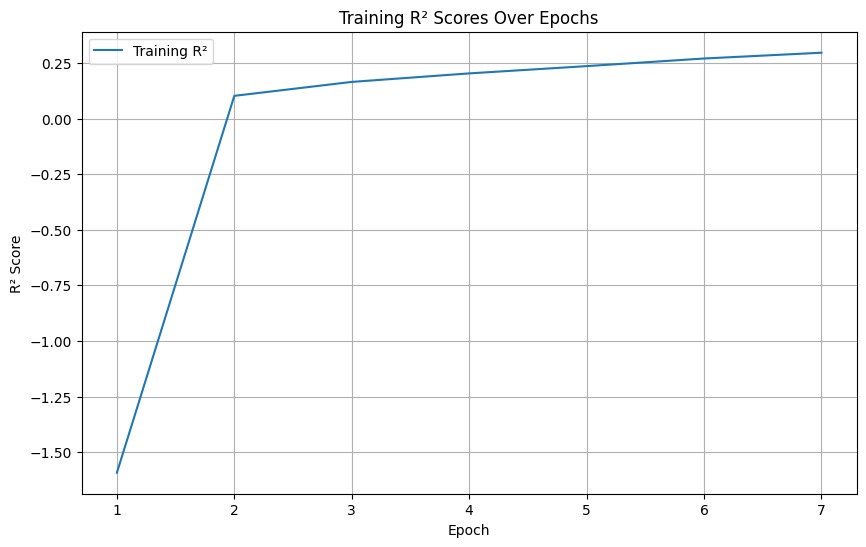

Training R2: ['-1.5927', '0.1021', '0.1647', '0.2030', '0.2357', '0.2700', '0.2960']
Validation R2: ['0.1360', '0.1902', '0.2021', '0.2252', '0.2354', '0.2412', '0.2325']


In [ ]:
if type(training_r2[0]) == torch.Tensor:
  for i in range(len(training_r2)):
    training_r2[i] = training_r2[i].item()

  for i in range(len(validation_r2)):
    validation_r2[i] = validation_r2[i].item()

plt.figure(figsize=(10, 6))
plt.plot(range(1, hp.num_epochs + 1), validation_r2, label='Validation R²')
plt.title('Validation R² Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, hp.num_epochs + 1), training_r2, label='Training R²')
plt.title('Training R² Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.show()

formatted_training_r2 = [f"{x:.4f}" for x in training_r2]
formatted_validation_r2 = [f"{x:.4f}" for x in validation_r2]
print(f'Training R2: {formatted_training_r2}')
print(f'Validation R2: {formatted_validation_r2}')